In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
 # Conexión a BD
# ==============================================================================
import pyodbc

In [3]:
# Configuración de BD y conexión
# ==============================================================================
direccion_servidor = '192.168.1.32,55078'
nombre_bd = 'BDVirunet'
nombre_usuario = 'sa'
password = '123456'

try:
    conexion = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + 
                              direccion_servidor+';DATABASE='+nombre_bd+';UID='+nombre_usuario+';PWD=' + password)
    print("Conexión exitosa")
    
except Exception as e:
    print("Ocurrió un error al conectar a SQL Server: ", e)

Conexión exitosa


In [4]:
dFechaInicio = '2020-01-01'
dFechaFin = '2020-12-31'

In [5]:
try:
    with conexion.cursor() as cursor:
            consulta = "exec STP_OBTENER_TOTALIZADO_PLAGAS ?,?,?,?"
            cursor.execute(consulta, (dFechaInicio, dFechaFin, 1,1))

            rows = cursor.fetchall()
            
            cols = []
            
            for i,_ in enumerate(cursor.description):
                cols.append(cursor.description[i][0])

            pd.DataFrame(np.array(rows), columns = cols)
            
            df = pd.DataFrame(columns =['Evaluador','Fecha','Fundo','Filtrado','Turno','Lote','Grupo_Plaga','Plaga','Caracteristica','Suma','Grado','Promedio','Porcentaje'] )
            for i in range(len(rows)):
                df.loc[i] = list(rows[i])
except Exception as e: 
    print(e)

In [6]:
dfPlaga =  df

In [7]:
filtradosEleg = ["17","20", "10N"]
dfFilEleg = dfPlaga[dfPlaga["Filtrado"].isin(filtradosEleg)]

In [8]:
dfFilEleg['Semana'] = pd.to_datetime(dfFilEleg['Fecha'], format='%Y-%m-%d').dt.weekofyear

In [9]:
data_weather = pd.ExcelFile('D:/Proyectos GitHub/Python/Datos/Datos Climaticos Viru Palto.xlsx')
df_weather = data_weather.parse('TABLA')  
data_weather.close()

In [10]:
df_weather = df_weather[df_weather['Año'] == 2020]
df_weather = df_weather[(df_weather['Fecha'] >= dFechaInicio) & (df_weather['Fecha'] <= dFechaFin)]
df_weather.reset_index(drop = True, inplace = True)

In [11]:
df_weather = df_weather[['Fecha','ET(mm).','Tº MIN/DIA (°C)','Tº MAX/DIA (°C)','Rad. Solar Prom.','HUMEDAD PROM.', 'T° Prom/Día (°C)','Semana']]
df_weather = df_weather.rename(columns = {'ET(mm).' : 'ET', 
                                      'Tº MIN/DIA (°C)' : 'T_MIN',
                                     'Tº MAX/DIA (°C)': 'T_MAX',
                                     'Rad. Solar Prom.' : 'RS_PROM',
                                     'HUMEDAD PROM.': 'HM_PROM',
                                      'T° Prom/Día (°C)': 'TMP_PROM',
                                         'Semana': 'Semana'})

In [12]:
import pickle

In [13]:
# Lugar: Filtrado 10N - Turno F10N - Lote 1017
# Plaga:  BEMISIA TABACI
# Caracteristica:  G° INFESTACIÓN (NINFAS-ADULTOS)
# Número de datos:  27
# Variables X: ['HM_PROM']
filename='bemisia_tabaci.pkl'
arrPlagas = []
dfFilter = dfFilEleg[(dfFilEleg["Plaga"] == "BEMISIA TABACI") & (dfFilEleg["Lote"] == "1017")]

**********************************************************************************************************************
Lugar: Filtrado 10N - Turno F10N - Lote 1017
Plaga:  BEMISIA TABACI
Caracteristica:  G° INFESTACIÓN (NINFAS-ADULTOS)
Número de datos:  27
Variables X: ['HM_PROM']



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     11.66
Date:                Mon, 29 Nov 2021   Prob (F-statistic):            0.00291
Time:                        18:18:49   Log-Likelihood:                0.96644
No. Observations:                  21   AIC:                             2.067
Df Residuals:                      19   BIC:                             4.156
Df Model:                           1                                         
Cova

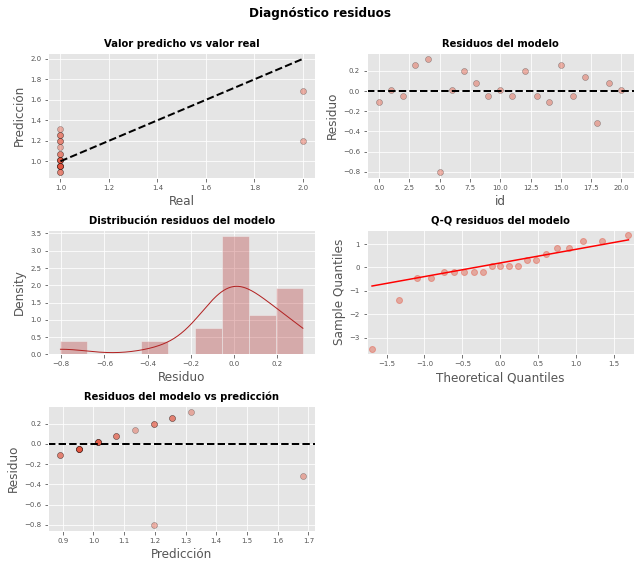


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
13  0.892857  0.079523       0.726414       1.059300      0.357819   
1   1.014286  0.058075       0.892733       1.135838      0.491468   
23  0.953571  0.067321       0.812667       1.094475      0.425919   
5   1.257143  0.071127       1.108272       1.406014      0.727307   

    obs_ci_upper  
13      1.427896  
1       1.537103  
23      1.481224  
5       1.786978  

El error (rmse) de test es: 0.4073125168645789
x_test
    const  HM_PROM
18    1.0     87.0
7     1.0     75.0
4     1.0     84.0
3     1.0     81.0
25    1.0     83.0
2     1.0     85.0

 y_test
[[1]
 [2]
 [2]
 [1]
 [1]
 [1]]



**********************************************************************************************************************


In [14]:
arrFiltrados = dfFilter['Filtrado'].unique()
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Grado'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','RS_PROM','HM_PROM','Grado']]        
                                   
                    df_union[["Grado"]] = df_union[["Grado"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Grado'] > 0.60]                
                    
                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 10:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Grado'] > 0.60) & (column != 'Grado'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                        
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                       
                      
                        if df_union[arrColumnsUnion].shape[0] > 1:   
                            print('**********************************************************************************************************************')
                            # División de los datos en train y test
                            # ==============================================================================
                            print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                            print('Plaga: ', plaga)
                            print('Caracteristica: ', caracteristica)
                            print('Número de datos: ',  df_union[arrColumnsUnion].shape[0])
                            print('Variables X:', arrColumnsUnion)
                            print("\n"*2)
                            
                            X = df_union[arrColumnsUnion]
                            y = df_union['Grado']

                            X_train, X_test, y_train, y_test = train_test_split(
                                                                    X,
                                                                    y.values.reshape(-1,1),
                                                                    train_size   = 0.8,
                                                                    random_state = 1234,
                                                                    shuffle      = True
                                                                )
                            # Creación del modelo utilizando matrices como en scikitlearn
                            # ==============================================================================
                            # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
                            X_train = sm.add_constant(X_train, prepend=True)
                            modelo = sm.OLS(endog=y_train, exog=X_train,)
                            modelo = modelo.fit()
                            print(modelo.summary())
                            
                            print('\n Coeficientes')
                            print(modelo.params)
                            
                            # Intervalos de confianza para los coeficientes del modelo
                            # ==============================================================================
                            intervalos_ci = modelo.conf_int(alpha=0.05)
                            intervalos_ci.columns = ['2.5%', '97.5%']
                            
                            print('\nIntervalos de confianza: ')
                            print(intervalos_ci)
                            
                            
                            print('\n Diagnostico de residuos:')
                            # Diagnóstico errores (residuos) de las predicciones de entrenamiento
                            # ==============================================================================
                            y_train = y_train.flatten()
                            prediccion_train = modelo.predict(exog = X_train)
                            residuos_train   = prediccion_train - y_train
                            
                            # Gráficos
                            # ==============================================================================
                            fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

                            axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                                            'k--', color = 'black', lw=2)
                            axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
                            axes[0, 0].set_xlabel('Real')
                            axes[0, 0].set_ylabel('Predicción')
                            axes[0, 0].tick_params(labelsize = 7)

                            axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[0, 1].set_xlabel('id')
                            axes[0, 1].set_ylabel('Residuo')
                            axes[0, 1].tick_params(labelsize = 7)

                            sns.histplot(
                                data    = residuos_train,
                                stat    = "density",
                                kde     = True,
                                line_kws= {'linewidth': 1},
                                color   = "firebrick",
                                alpha   = 0.3,
                                ax      = axes[1, 0]
                            )

                            axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                                                 fontweight = "bold")
                            axes[1, 0].set_xlabel("Residuo")
                            axes[1, 0].tick_params(labelsize = 7)


                            sm.qqplot(
                                residuos_train,
                                fit   = True,
                                line  = 'q',
                                ax    = axes[1, 1], 
                                color = 'firebrick',
                                alpha = 0.4,
                                lw    = 2
                            )
                            axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[1, 1].tick_params(labelsize = 7)

                            axes[2, 0].scatter(prediccion_train, residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
                            axes[2, 0].set_xlabel('Predicción')
                            axes[2, 0].set_ylabel('Residuo')
                            axes[2, 0].tick_params(labelsize = 7)

                            # Se eliminan los axes vacíos
                            fig.delaxes(axes[2,1])

                            fig.tight_layout()
                            plt.subplots_adjust(top=0.9)
                            fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
                            plt.show()
                            
                            # Predicciones con intervalo de confianza 
                            # ==============================================================================
                            predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
                            print('\n Predicciones:')
                            print(predicciones.head(4))
                            
                            # Error de test del modelo 
                            # ==============================================================================
                            X_test = sm.add_constant(X_test, prepend=True)
                            predicciones = modelo.predict(exog = X_test)
                            rmse = mean_squared_error(
                                    y_true  = y_test,
                                    y_pred  = predicciones,
                                    squared = False
                                   )
                            print("")
                            print(f"El error (rmse) de test es: {rmse}")
                            
                            print("x_test")
                            print(X_test)
                            print("\n y_test")
                            print(y_test)
                            
                            pickle.dump(modelo, open(filename, 'wb'))
                            
                            print("\n"*2)
                            print('**********************************************************************************************************************')
                            

In [87]:
model = pickle.load(open("bemisia_tabaci.pkl", "rb"))

In [89]:
final_features = [np.array([1,87])]
model.predict(final_features)

array([0.95357143])

In [25]:
# Lugar: Filtrado 17 - Turno F17 - Lote 1718
# Plaga:  TRIPS TABACI
# Caracteristica:  G° NINFAS Y ADULTOS/ INFLORESC.
# Número de datos:  26
# Variables X: ['TMP_PROM']
filename = "trips_tabaci.pkl"
arrPlagas = []
dfFilter = dfFilEleg[(dfFilEleg["Plaga"] == "TRIPS TABACI") & (dfFilEleg["Lote"] == "1718")]

**********************************************************************************************************************
Lugar: Filtrado 17 - Turno F17 - Lote 1718
Plaga:  TRIPS TABACI
Caracteristica:  G° NINFAS Y ADULTOS/ INFLORESC.
Número de datos:  26
Variables X: ['TMP_PROM']



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     8.952
Date:                Mon, 29 Nov 2021   Prob (F-statistic):            0.00782
Time:                        18:43:55   Log-Likelihood:                -26.573
No. Observations:                  20   AIC:                             57.15
Df Residuals:                      18   BIC:                             59.14
Df Model:                           1                                         
Covaria

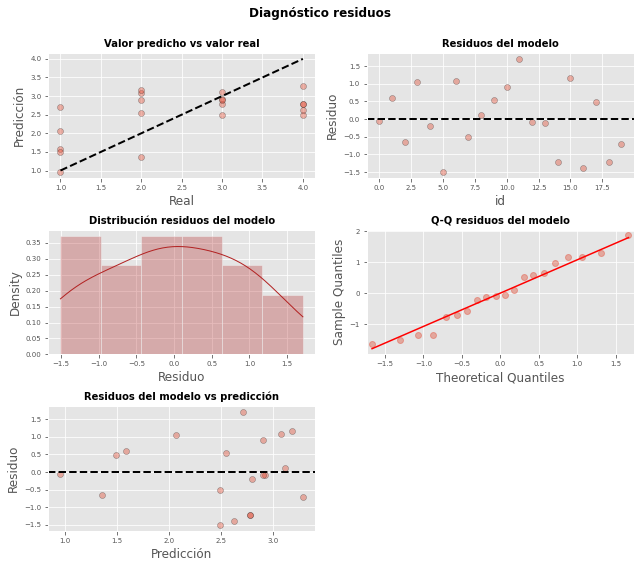


 Predicciones:
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
5  0.954054  0.559775      -0.221989       2.130097     -1.386299   
4  1.585564  0.373879       0.800073       2.371054     -0.584960   
0  1.357754  0.438318       0.436881       2.278627     -0.865348   
8  2.062905  0.260231       1.516180       2.609629     -0.033064   

   obs_ci_upper  
5      3.294407  
4      3.756087  
0      3.580856  
8      4.158873  

El error (rmse) de test es: 0.6486466120792844
x_test
    const   TMP_PROM
7     1.0  21.900000
16    1.0  16.462500
2     1.0  22.941667
3     1.0  22.829167
1     1.0  22.833333
18    1.0  17.241667

 y_test
[[1]
 [4]
 [2]
 [1]
 [2]
 [3]]



**********************************************************************************************************************


In [26]:
arrFiltrados = dfFilter['Filtrado'].unique()
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Grado'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','RS_PROM','HM_PROM','Grado']]        
                                   
                    df_union[["Grado"]] = df_union[["Grado"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Grado'] > 0.60]                
                    
                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 10:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Grado'] > 0.60) & (column != 'Grado'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                        
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                       
                      
                        if df_union[arrColumnsUnion].shape[0] > 1:   
                            print('**********************************************************************************************************************')
                            # División de los datos en train y test
                            # ==============================================================================
                            print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                            print('Plaga: ', plaga)
                            print('Caracteristica: ', caracteristica)
                            print('Número de datos: ',  df_union[arrColumnsUnion].shape[0])
                            print('Variables X:', arrColumnsUnion)
                            print("\n"*2)
                            
                            X = df_union[arrColumnsUnion]
                            y = df_union['Grado']

                            X_train, X_test, y_train, y_test = train_test_split(
                                                                    X,
                                                                    y.values.reshape(-1,1),
                                                                    train_size   = 0.8,
                                                                    random_state = 1234,
                                                                    shuffle      = True
                                                                )
                            # Creación del modelo utilizando matrices como en scikitlearn
                            # ==============================================================================
                            # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
                            X_train = sm.add_constant(X_train, prepend=True)
                            modelo = sm.OLS(endog=y_train, exog=X_train,)
                            modelo = modelo.fit()
                            print(modelo.summary())
                            
                            print('\n Coeficientes')
                            print(modelo.params)
                            
                            # Intervalos de confianza para los coeficientes del modelo
                            # ==============================================================================
                            intervalos_ci = modelo.conf_int(alpha=0.05)
                            intervalos_ci.columns = ['2.5%', '97.5%']
                            
                            print('\nIntervalos de confianza: ')
                            print(intervalos_ci)
                            
                            
                            print('\n Diagnostico de residuos:')
                            # Diagnóstico errores (residuos) de las predicciones de entrenamiento
                            # ==============================================================================
                            y_train = y_train.flatten()
                            prediccion_train = modelo.predict(exog = X_train)
                            residuos_train   = prediccion_train - y_train
                            
                            # Gráficos
                            # ==============================================================================
                            fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

                            axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                                            'k--', color = 'black', lw=2)
                            axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
                            axes[0, 0].set_xlabel('Real')
                            axes[0, 0].set_ylabel('Predicción')
                            axes[0, 0].tick_params(labelsize = 7)

                            axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[0, 1].set_xlabel('id')
                            axes[0, 1].set_ylabel('Residuo')
                            axes[0, 1].tick_params(labelsize = 7)

                            sns.histplot(
                                data    = residuos_train,
                                stat    = "density",
                                kde     = True,
                                line_kws= {'linewidth': 1},
                                color   = "firebrick",
                                alpha   = 0.3,
                                ax      = axes[1, 0]
                            )

                            axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                                                 fontweight = "bold")
                            axes[1, 0].set_xlabel("Residuo")
                            axes[1, 0].tick_params(labelsize = 7)


                            sm.qqplot(
                                residuos_train,
                                fit   = True,
                                line  = 'q',
                                ax    = axes[1, 1], 
                                color = 'firebrick',
                                alpha = 0.4,
                                lw    = 2
                            )
                            axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[1, 1].tick_params(labelsize = 7)

                            axes[2, 0].scatter(prediccion_train, residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
                            axes[2, 0].set_xlabel('Predicción')
                            axes[2, 0].set_ylabel('Residuo')
                            axes[2, 0].tick_params(labelsize = 7)

                            # Se eliminan los axes vacíos
                            fig.delaxes(axes[2,1])

                            fig.tight_layout()
                            plt.subplots_adjust(top=0.9)
                            fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
                            plt.show()
                            
                            # Predicciones con intervalo de confianza 
                            # ==============================================================================
                            predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
                            print('\n Predicciones:')
                            print(predicciones.head(4))
                            
                            # Error de test del modelo 
                            # ==============================================================================
                            X_test = sm.add_constant(X_test, prepend=True)
                            predicciones = modelo.predict(exog = X_test)
                            rmse = mean_squared_error(
                                    y_true  = y_test,
                                    y_pred  = predicciones,
                                    squared = False
                                   )
                            print("")
                            print(f"El error (rmse) de test es: {rmse}")
                            
                            print("x_test")
                            print(X_test)
                            print("\n y_test")
                            print(y_test)
                            
                            pickle.dump(modelo, open(filename, 'wb'))
                            
                            print("\n"*2)
                            print('**********************************************************************************************************************')
                            

In [84]:
model = pickle.load(open("trips_tabaci.pkl", "rb"))
model

In [86]:
final_features = [np.array([0,20])]
model.predict([[1,20]])

array([2.05230873])

In [46]:
# Lugar: Filtrado 20 - Turno F20 - Lote 2019
# Plaga:  OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI
# Caracteristica:  G° INFESTACIÓN (HUEVOS)
# Número de datos:  42
# Variables X: ['TMP_PROM', 'HM_PROM']
filename = "olygonichus_huevos.pkl"
arrPlagas = []
dfFilter = dfFilEleg[(dfFilEleg["Plaga"] == "OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI") & (dfFilEleg["Lote"] == "2019")]

In [60]:
arrFiltrados = dfFilter['Filtrado'].unique()
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Grado'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','RS_PROM','HM_PROM','Grado']]        
                                   
                    df_union[["Grado"]] = df_union[["Grado"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Grado'] > 0.60]                
                    
                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 10:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Grado'] > 0.60) & (column != 'Grado'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                        
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                       
                      
                        if df_union[arrColumnsUnion].shape[0] > 1:   
                            print('**********************************************************************************************************************')
                            # División de los datos en train y test
                            # ==============================================================================
                            print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                            print('Plaga: ', plaga)
                            print('Caracteristica: ', caracteristica)
                            print('Número de datos: ',  df_union[arrColumnsUnion].shape[0])
                            print('Variables X:', arrColumnsUnion)
                            print("\n"*2)
                            
                            X = df_union[arrColumnsUnion]
                            y = df_union['Grado']

                            X_train, X_test, y_train, y_test = train_test_split(
                                                                    X,
                                                                    y,
                                                                    train_size   = 0.8,
                                                                    random_state = 1234,
                                                                    shuffle      = True
                                                                )
                            # Creación del modelo utilizando matrices como en scikitlearn
                            # ==============================================================================
                            # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
                            X_train = sm.add_constant(X_train, prepend=True)
                            modelo = sm.OLS(endog=y_train, exog=X_train,)
                            modelo = modelo.fit()
                            print(modelo.summary())
                            
                            pickle.dump(modelo, open(filename, 'wb'))
                            print('\n Coeficientes')
                            print(modelo.params)
                            
                            # Intervalos de confianza para los coeficientes del modelo
                            # ==============================================================================
                            intervalos_ci = modelo.conf_int(alpha=0.05)
                            intervalos_ci.columns = ['2.5%', '97.5%']
                            
                            print('\nIntervalos de confianza: ')
                            print(intervalos_ci)
                            
                            
                            print('\n Diagnostico de residuos:')
                            # Diagnóstico errores (residuos) de las predicciones de entrenamiento
                            # ==============================================================================
                            y_train = y_train.flatten()
                            prediccion_train = modelo.predict(exog = X_train)
                            residuos_train   = prediccion_train - y_train
                            
                            # Gráficos
                            # ==============================================================================
                            fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

                            axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                                            'k--', color = 'black', lw=2)
                            axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
                            axes[0, 0].set_xlabel('Real')
                            axes[0, 0].set_ylabel('Predicción')
                            axes[0, 0].tick_params(labelsize = 7)

                            axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[0, 1].set_xlabel('id')
                            axes[0, 1].set_ylabel('Residuo')
                            axes[0, 1].tick_params(labelsize = 7)

                            sns.histplot(
                                data    = residuos_train,
                                stat    = "density",
                                kde     = True,
                                line_kws= {'linewidth': 1},
                                color   = "firebrick",
                                alpha   = 0.3,
                                ax      = axes[1, 0]
                            )

                            axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                                                 fontweight = "bold")
                            axes[1, 0].set_xlabel("Residuo")
                            axes[1, 0].tick_params(labelsize = 7)


                            sm.qqplot(
                                residuos_train,
                                fit   = True,
                                line  = 'q',
                                ax    = axes[1, 1], 
                                color = 'firebrick',
                                alpha = 0.4,
                                lw    = 2
                            )
                            axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[1, 1].tick_params(labelsize = 7)

                            axes[2, 0].scatter(prediccion_train, residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
                            axes[2, 0].set_xlabel('Predicción')
                            axes[2, 0].set_ylabel('Residuo')
                            axes[2, 0].tick_params(labelsize = 7)

                            # Se eliminan los axes vacíos
                            fig.delaxes(axes[2,1])

                            fig.tight_layout()
                            plt.subplots_adjust(top=0.9)
                            fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
                            plt.show()
                            
                            # Predicciones con intervalo de confianza 
                            # ==============================================================================
                            predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
                            print('\n Predicciones:')
                            print(predicciones.head(4))
                            
                            # Error de test del modelo 
                            # ==============================================================================
                            X_test = sm.add_constant(X_test, prepend=True)
                            predicciones = modelo.predict(exog = X_test)
                            rmse = mean_squared_error(
                                    y_true  = y_test,
                                    y_pred  = predicciones,
                                    squared = False
                                   )
                            print("")
                            print(f"El error (rmse) de test es: {rmse}")
                            
                            print("x_test")
                            print(X_test)
                            print("\n y_test")
                            print(y_test)
                            
                            
                            print("\n"*2)
                            print('**********************************************************************************************************************')
                            

**********************************************************************************************************************
Lugar: Filtrado 20 - Turno F20 - Lote 2019
Plaga:  OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI
Caracteristica:  G° INFESTACIÓN (HUEVOS)
Número de datos:  42
Variables X: ['TMP_PROM', 'HM_PROM']



                            OLS Regression Results                            
Dep. Variable:                  Grado   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     15.89
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           1.96e-05
Time:                        19:19:21   Log-Likelihood:                -28.750
No. Observations:                  33   AIC:                             63.50
Df Residuals:                      30   BIC:                             67.99
Df Model:                           2                 

AttributeError: 'Series' object has no attribute 'flatten'

In [61]:
model = pickle.load(open("olygonichus_huevos.pkl", "rb"))
model

In [62]:
final_features = [np.array([20,0])]
model.predict([21,80,0])

array([142.08994086])

In [66]:
modelo.params

const       6.295487
TMP_PROM    0.123559
HM_PROM    -0.078251
dtype: float64

In [65]:
Xnew = [[-0.79415228, 2.10495117]]
# make a prediction
ynew = modelo.predict()
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

X=[-0.79415228, 2.10495117], Predicted=1.7598457678984856


In [68]:
model.predict()

array([1.75984577, 2.54546885, 2.16605208, 1.2656221 , 3.31356627,
       3.01601039, 3.35321425, 2.63530653, 2.87443852, 2.50377077,
       1.80386059, 1.88288379, 1.59047313, 1.83784545, 2.0002158 ,
       1.53715545, 3.19542526, 2.12329363, 2.13179752, 2.20748968,
       1.68803018, 1.6818553 , 1.2290723 , 1.75531496, 1.54697007,
       1.66202824, 1.39895977, 1.53564383, 2.89785403, 1.61878873,
       2.46438634, 2.13978044, 1.63757999])

In [76]:
model.predict([[1,10,20]])

array([-0.32942924])

In [80]:
print(1*6.295487 + 20*0.123559 - 0.078251 * 85 )

2.1153319999999995
